# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Python Installation**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Strategy Analytics for RNN
In this notebook, you will learn to do a trade-wise analysis of the strategy based on the recurrent neural network (RNN) you saw in the previous notebook. By the end of this notebook, you will have a trade wise list with the entry time, exit time and the profit or loss for each trade.

You will also have a summary of the strategy that will include the total number of trades along with the analytics for win percentage, net profit, average profit per trade, etc.

The notebook is structured as follows:
* [Read the Strategy Data](#read)
* [Trade-wise Analytics](#single)
* [Strategy Analytics](#strat)

## Import Libraries

In [1]:
# Data manipulation
import warnings
import pandas as pd
import numpy as np

# Data visualisation
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")

# Ignore warnings
warnings.filterwarnings('ignore')

<a id='read'></a>
## Read the Strategy Data
The strategy data is stored in the CSV file `performance_rnn.csv` in the `data_modules` folder.

In [2]:
# Read CSV file
data = pd.read_csv('../data_modules/performance_rnn.csv', index_col=0, parse_dates=True)

We will create a signal which is 1 when the predicted price of the current day is more than the previous day's actual price. And -1 otherwise.

In [3]:
# create signal
data['signal'] = np.where((data['Predicted']>data['Actual'].shift(1)),1,-1)
# drop na values, if any
data.dropna(inplace = True)
data.tail()

,Predicted,Actual,signal
Date,,,
2018-12-14 00:00:00+00:00,293.111847,291.90,-1
2018-12-17 00:00:00+00:00,291.329620,293.05,-1
2018-12-18 00:00:00+00:00,290.725250,294.15,-1
2018-12-19 00:00:00+00:00,289.024963,292.15,-1
2018-12-20 00:00:00+00:00,288.124451,294.80,-1


<a id='single'></a>
## Trade-wise Analytics
We will create a function `get_trades`. The function will take the dataframe with the signals and close price as input along with the column names for signals and close price.

It will return a dataframe containing the details of each trade that was taken during the backtest. The details will include:
* Trade direction (`Position`)
* Entry time
* Entry price
* Exit time
* Exit price
* Profit or Loss<br>
for each trade.

In [4]:
def get_trades(data, close_column, signal_column):
    # Create a dataframe to store value of each trade
    trades = pd.DataFrame()

    # Set current position as 0, and entry time aas empty
    current_position = 0
    entry_time = ''

    # Loop through each trade in dataframe
    for i in data.index:
        # Each row in the dataframe will be treated as a new position
        new_position = data.loc[i, signal_column]

        # If the position changes from long to short or vice-versa,
        # or from long to neutral, or short to neutral, record the entry and exit
        if new_position != current_position:
            if entry_time != '':
                entry_price = data.loc[entry_time, close_column]
                exit_time = i
                exit_price = data.loc[exit_time, close_column]
                trade_details = pd.DataFrame(
                    [(current_position, entry_time, entry_price, exit_time, exit_price)])
                trades = trades.append(trade_details, ignore_index=True)
                entry_time = ''

            if new_position != 0:
                entry_time = i
            current_position = new_position

    # Add the trade details to the `trades` dataframe
    trades.columns = ['Position', 'Entry Time',
                      'Entry Price', 'Exit Time', 'Exit Price']
    trades['PnL'] = (trades['Exit Price'] -
                     trades['Entry Price']) * trades['Position']
    return trades


# Get trade details for hit ratio strategy
trade_log = get_trades(data, 'Actual', 'signal')

trade_log.head()

,Position,Entry Time,Entry Price,Exit Time,Exit Price,PnL
0,-1,2018-10-01 00:00:00+00:00,271.70,2018-10-03 00:00:00+00:00,258.35,13.35
1,1,2018-10-03 00:00:00+00:00,258.35,2018-10-05 00:00:00+00:00,262.95,4.60
2,-1,2018-10-05 00:00:00+00:00,262.95,2018-10-08 00:00:00+00:00,278.65,-15.70
3,1,2018-10-08 00:00:00+00:00,278.65,2018-10-09 00:00:00+00:00,262.15,-16.50
4,-1,2018-10-09 00:00:00+00:00,262.15,2018-10-10 00:00:00+00:00,263.75,-1.60


<a id='strat'></a>
## Strategy Analytics
We will define a function `get_analytics`. The function will take the trade log that we generated earlier and return the following:
* Number of long trades
* Number of short trades
* Total number of trades
* Gross profit
* Gross loss
* Net profit/loss
* Number of winning trades
* Number of losing trades
* Win percentage
* Loss percentage
* Average profit per winning trade
* Average loss per losing trade

In [5]:
def get_analytics(trades):

    # Creating the dataframe to store the parameters
    analytics = pd.DataFrame(index=['Strategy'])

    # Number of long trades
    analytics['num_of_long'] = len(trades.loc[trades.Position == 1])

    # Number of short trades
    analytics['num_of_short'] = len(trades.loc[trades.Position == -1])

    # Total number of trades
    analytics['total_trades'] = analytics.num_of_long + analytics.num_of_short

    # Gross Profit
    analytics['gross_profit'] = trades.loc[trades.PnL > 0].PnL.sum()

    # Gross Loss
    analytics['gross_loss'] = trades.loc[trades.PnL < 0].PnL.sum()

    # Net Profit
    analytics['net_profit'] = trades.PnL.sum()

    # Profitable trades
    analytics['winners'] = len(trades.loc[trades.PnL > 0])

    # Loss-making trades
    analytics['losers'] = len(trades.loc[trades.PnL <= 0])

    # Win percentage
    analytics['win_percentage'] = 100*analytics.winners/analytics.total_trades

    # Loss percentage
    analytics['loss_percentage'] = 100*analytics.losers/analytics.total_trades

    # Per trade profit/loss of winning trades
    analytics['per_trade_PnL_winners'] = trades.loc[trades.PnL > 0].PnL.mean()

    # Per trade profit/loss of losing trades
    analytics['per_trade_PnL_losers'] = trades.loc[trades.PnL <= 0].PnL.mean()
    analytics = round(analytics, 2)

    analytics.columns = ["Number of long trades", "Number of short trades", "Total number of trades", "Gross profit", "Gross loss", "Net profit",
                         "Number of winners", "Number of losers", "Winning percentage", "Losing percentage", "Avg. profit per winning trade", "Avg. loss per losing trade"]
    return analytics.T


# Get strategy analytics
analytics = get_analytics(trade_log)

analytics

,Strategy
Number of long trades,9.00
Number of short trades,9.00
Total number of trades,18.00
Gross profit,43.55
Gross loss,-68.10
Net profit,-24.55
Number of winners,8.00
Number of losers,10.00
Winning percentage,44.44
Losing percentage,55.56


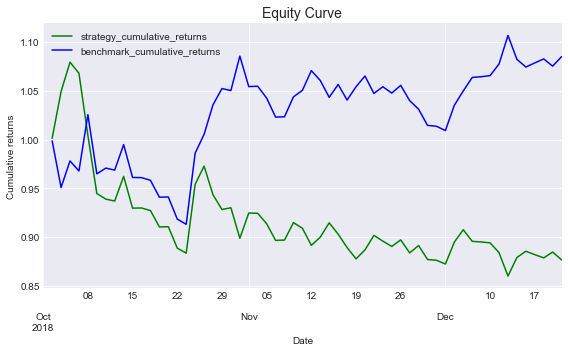

In [6]:
# Calculate daily returns
data['returns'] = data["Actual"].pct_change()

# Calculate strategy returns
data['strategy_returns'] = data['returns'] * data['signal'].shift(1)

# Calculate the cumulative returns
strategy_data=pd.DataFrame()
strategy_data['strategy_cumulative_returns'] = (1 + data['strategy_returns']).cumprod()

strategy_data['benchmark_cumulative_returns'] = (
    1+data['returns']).cumprod()

# ---------------------Equity Curve---------------------
# Plot cumulative strategy returns
strategy_data['strategy_cumulative_returns'].plot(
    figsize=(8, 5), color='green')
strategy_data['benchmark_cumulative_returns'].plot(
    figsize=(8, 5), color='blue')
plt.title('Equity Curve', fontsize=14)
plt.legend()
plt.ylabel('Cumulative returns')
plt.tight_layout()
plt.show()

The maximum drawdown is -20.31%.


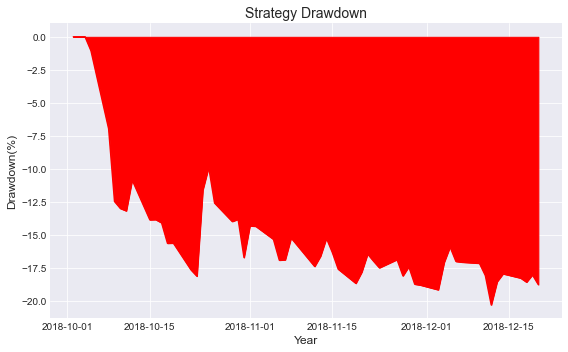

In [7]:
# Calculate the running maximum
running_max = np.maximum.accumulate(
    strategy_data['strategy_cumulative_returns'].dropna())
# Ensure the value never drops below 1
running_max[running_max < 1] = 1
# Calculate the percentage drawdown
drawdown = (
    (strategy_data['strategy_cumulative_returns'])/running_max - 1) * 100

# Calculate the maximum drawdown
max_dd = drawdown.min()
print("The maximum drawdown is {0:.2f}%.".format(max_dd))

# ---------------------DD plot---------------------
fig = plt.figure(figsize=(8, 5))

# Plot max drawdown
plt.plot(drawdown, color='red')
# Fill in-between the drawdown
plt.fill_between(drawdown.index, drawdown.values, color='red')
plt.title('Strategy Drawdown', fontsize=14)
plt.ylabel('Drawdown(%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

plt.tight_layout()
plt.show()

You have learned to generate detailed trade reports for the RNN strategy. In the upcoming notebooks, you can use the functions created in this notebook, for analysing the strategies.<br><br>